<a href="https://colab.research.google.com/github/czovekboti/ABT-MLHF/blob/main/MLHW_Data_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get dataset
Download dataset from kaggle. Api json file is needed that has to be put in the same repository as this notebook or change 'KAGGLE_CONFIG_DIR' variable to the correct repository.


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = r"./"

In [7]:
!pip install kaggle
!kaggle competitions download -c airbus-ship-detection -p .


^C


In [8]:
import zipfile
import os

zip_path = "airbus-ship-detection.zip"
extract_dir = "./airbus_data"

# Make sure target folder exists
os.makedirs(extract_dir, exist_ok=True)

# Extract with progress info
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    print(f"Extracting {len(zip_ref.infolist())} files...")
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

FileNotFoundError: [Errno 2] No such file or directory: 'airbus-ship-detection.zip'

## Load Airbus Ship Detection Dataset

In [ ]:
import pandas as pd
import os

#Get data tturn csv into pandas dataset
DATA_DIR      = './airbus_data/'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_v2")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test_v2")
train_csv = os.path.join(DATA_DIR, 'train_ship_segmentations_v2.csv')
train_df = pd.read_csv(train_csv)
print(train_df.shape)
train_df.head()


(231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Check for Missing Values and Image Statistics

In the Airbus Ship Detection dataset, each image may have one or more ship masks stored in the "EncodedPixels" column.  
If an image contains no ships, the value in "EncodedPixels" is NaN.  

In [ ]:
# Missing values (if no ship -> encoded pixels is nan)
missing_masks = train_df['EncodedPixels'].isnull().sum()
print("Pictures without boats:", missing_masks)
not_missing_masks = train_df['EncodedPixels'].notnull().sum()
print("Pictures with boats", not_missing_masks)
# One picture can have more masks -> needs grouping
unique_images = train_df['ImageId'].nunique()
print("Unique pictures:", unique_images)


Pictures without boats: 150000
Pictures with boats 81723
Unique pictures: 192556


In [ ]:
# Filter duplications
train_df = train_df.drop_duplicates(subset=['ImageId', 'EncodedPixels'])
# Checking actual existance of files
train_images = set(os.listdir(os.path.join(DATA_DIR, 'train_v2')))
train_df = train_df[train_df['ImageId'].isin(train_images)]
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
# Labeling(1 if has ship else 0)
train_df['has_ship'] = train_df['EncodedPixels'].notnull().astype(int)

# Group all rows that belong to same image
image_grouped = train_df.groupby('ImageId')['has_ship'].max().reset_index()
image_grouped.rename(columns={'has_ship': 'has_ship_label'}, inplace=True)

# Balancing due to lot of empty pictures -> 1:2 ratio of has ships and no ships so it doesnt overfit.
positive = image_grouped[image_grouped['has_ship_label'] == 1]
negative = image_grouped[image_grouped['has_ship_label'] == 0].sample(len(positive) * 2, random_state=42)
balanced_df = pd.concat([positive, negative])


## Decode RLE masks
This cell defines rle_decode to convert run-length encoding to a binary mask array.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Take in rle string and output binary mask with given shape
def rle_decode(mask_rle, shape=(768, 768)):
    # Return full black mask if RLE is missing
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    # RLE odd nums -> length even nums-> start values
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Transpose to align with right direction


## Split dataframe into validation, train and test

Dataset is split into 80% training 10% validation and 10% test data.
Stratify sampling was used to make that the dataset is balanced in every group.

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, temp_ids = train_test_split(
    small_df['ImageId'],
    test_size=0.2,
    stratify=small_df['has_ship_label'],
    random_state=42
)
temp_labels = small_df.set_index('ImageId').loc[temp_ids]['has_ship_label']
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)
print("Train:", len(train_ids))
print("Val:", len(val_ids))
print("Test:", len(test_ids))

Train: 80
Val: 10
Test: 10


## Custom PyTorch Dataset for Airbus Ship Detection
**__init__:**
- Stores the input dataframe, image directory path and transformations.
- Loads csv
**__getitem__:**
- Retrieves the image filename using the given index.
- Opens the corresponding image and converts it to RGB.
- Collects all mask rows belonging to that image ID, decodes them from RLE, and merges them into one binary mask.
- Applies transformation if given.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class AirbusDataset(Dataset):
    def __init__(self, df, base_path, transforms=None):
        self.df = df
        self.base_path = base_path
        self.transforms = transforms  # picture processing functions
        self.masks = pd.read_csv(train_csv)

    # Load image with mask
    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]['ImageId']
        image_path = os.path.join(self.base_path, image_id)
        image = Image.open(image_path).convert("RGB")

        mask_df = self.masks[self.masks['ImageId'] == image_id]
        mask = np.zeros((768, 768), dtype=np.uint8)
        for _, row in mask_df.iterrows():
            mask |= rle_decode(row['EncodedPixels'])


        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

    def __len__(self):
        return len(self.df)


## Data Augmentation and Preprocessing with Albumentations
 - This cell defines the image transformations applied to training and validation data.
 - Albumentations is used to resize, normalize, and augment images and masks in a consistent way.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Augmentation so the model can learn different setups
train_transforms = A.Compose([
    #A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])
val_transforms = A.Compose([
    #A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# Create and visualize datasets
- Initializing val, train, and test datasets
- Visualize a few samples (image, mask, and overlay) as a sanity check to confirm that masks correct and are aligned.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


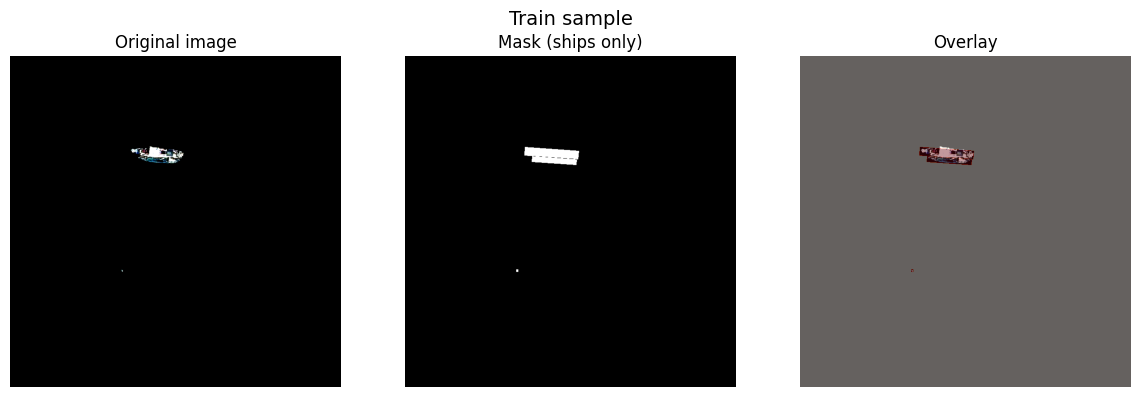

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7172984..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7172984..2.6399999].


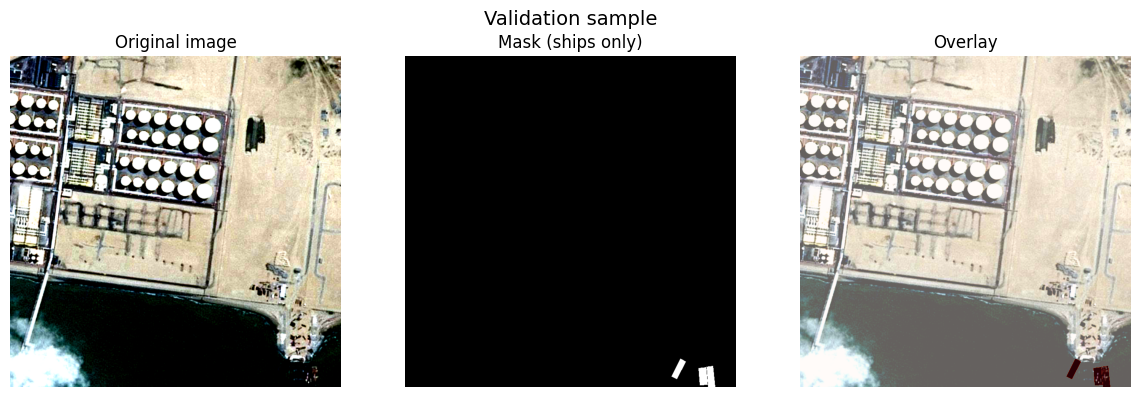

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116775].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116775].


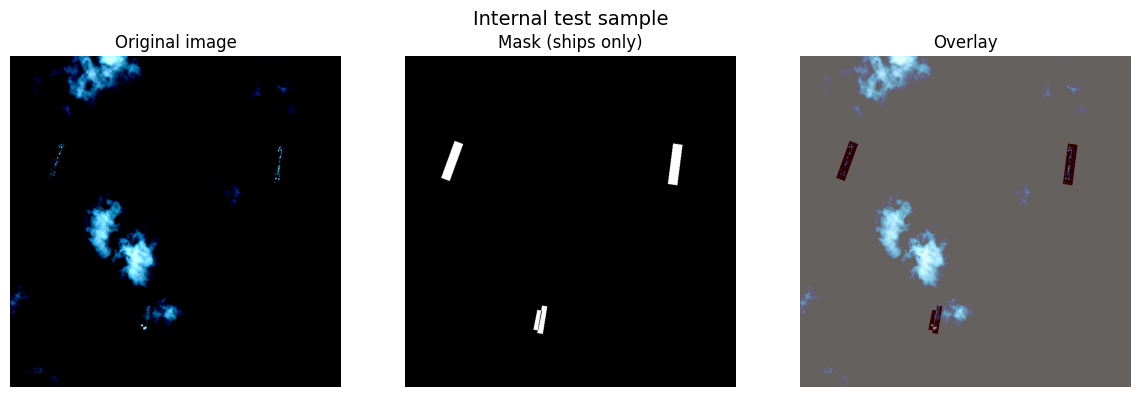

In [ ]:

train_dataset = AirbusDataset(train_df[train_df['ImageId'].isin(train_ids)], TRAIN_IMG_DIR, transforms=train_transforms)
val_dataset   = AirbusDataset(train_df[train_df['ImageId'].isin(val_ids)],   TRAIN_IMG_DIR, transforms=val_transforms)
test_dataset  = AirbusDataset(train_df[train_df['ImageId'].isin(test_ids)],  TRAIN_IMG_DIR, transforms=val_transforms)
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(dataset, index=0, title="Sample"):
    # Get one image–mask pair
    image, mask = dataset[index]
    if hasattr(image, "permute"):  # PyTorch tensor [C,H,W] → [H,W,C]
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        image_np = np.array(image)

    mask_np = mask.cpu().numpy() if hasattr(mask, "cpu") else np.array(mask)
    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=14)
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original image")
    plt.axis("off")

    # Binary mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Mask (ships only)")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image_np)
    plt.imshow(mask_np, alpha=0.4, cmap="Reds")
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualizing sanity check
visualize_sample(train_dataset, index=1, title="Train sample")
visualize_sample(val_dataset,   index=1, title="Validation sample")
visualize_sample(test_dataset,  index=1, title="Internal test sample")